In [1]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-04-30 06:02:44--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-04-30 06:02:45--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc162c38b234e2cae466a1bd2bc2.dl-eu.dropboxusercontent.com/cd/0/inline/B7JdBn05aQvRMH8tmdT2whYtDptPzrq9dG_6WQlPkgVPF7SK3FQz_OCenRZ80LNYkc5tCBJlcWSaJYuelRV0O0faf_U0NXDzg85owu3QJGpc7_Xp9M-DIACvX5O5huWeRVWI8TQsI9au6isypT-6NimuqMWjqjy-YUm1hNZfEyoNHw/file# [following]
--2023-04-30 06:02:45--  https://uc162c38b234e2cae466a1bd2bc2.dl-eu.dropboxusercontent.com/cd/0/inline/B7JdBn05aQvRMH8tmdT2whYtDptPzrq9dG_6WQlPkgVPF7SK3FQz_OCen

# Data loading

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import pandas as pd

In [4]:
# dataloader class
class MycsvDataset(Dataset):
  def __init__(self,path_csv):
    super().__init__()
    self.data = pd.read_csv(path_csv).to_numpy()
    self.images = self.data[:,1:]
    self.labels = self.data[:,1]
  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    im = self.images[idx,:]
    label = self.labels[idx]
    im = np.reshape(im,(1,28,28))/255 
    return (im,label)

In [5]:
data = MycsvDataset("fashion-mnist_train.csv")


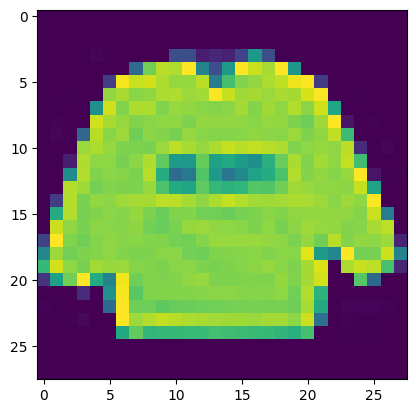

In [6]:
plt.imshow(data[0][0][0])

In [7]:
train_loader = DataLoader(data, batch_size=64)
t1 = iter(train_loader)
batch=next(t1)

#Auto encoder

In [8]:
class AutoEncoderConv(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear( 7*7*64, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, nz)


    self.plinear1 = nn.Linear(nz,nz)
    self.plinear2 = nn.Linear(nz,nz)

    self.dlinear1 = nn.Linear(nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 7*7*64)
    self.dbn2 = nn.BatchNorm1d(7*7*64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding= 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding= 1)


  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)
    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)
    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,7*7*64)
    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)
    x = torch.sigmoid(self.elinear2(x))
    return x

  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return (mu, logvar)


  def reparm(self, mu, logvar):
    eps = torch.randn(mu.shape).to(device)
    z = mu + eps* torch.exp(0.5*logvar)
    return z

    # log val =log sigma^2 = 2*log sigma--->. o.5*2*log sigma =log sigma



  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)
    x = x.view(-1,64 ,7 ,7 )
    x = torch.relu(self.dconv1(x))
    x = self.dbn3(x)
    x = torch.relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x


  def forward(self,x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = self.reparm(mu, logvar)
    x = self.decoder(z)
    return (z, mu, logvar, x)




In [9]:
device = torch.device("cuda:0")

In [10]:
def vae_loss(xhat, x, mu, logvar):
  KL_WEIGHT = 0.00012
  recon_loss = F.mse_loss(xhat, x)
  kl_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar) - mu*mu), axis =1), axis =0)
  return (1-KL_WEIGHT)*recon_loss + (KL_WEIGHT)*kl_loss

#Training

epoc0 / epoc20 loss: 0
epoc1 / epoc20 loss: 0
epoc2 / epoc20 loss: 0
epoc3 / epoc20 loss: 0
epoc4 / epoc20 loss: 0
epoc5 / epoc20 loss: 0
epoc6 / epoc20 loss: 0
epoc7 / epoc20 loss: 0
epoc8 / epoc20 loss: 0
epoc9 / epoc20 loss: 0
epoc10 / epoc20 loss: 0
epoc11 / epoc20 loss: 0
epoc12 / epoc20 loss: 0
epoc13 / epoc20 loss: 0
epoc14 / epoc20 loss: 0
epoc15 / epoc20 loss: 0
epoc16 / epoc20 loss: 0
epoc17 / epoc20 loss: 0
epoc18 / epoc20 loss: 0
epoc19 / epoc20 loss: 0


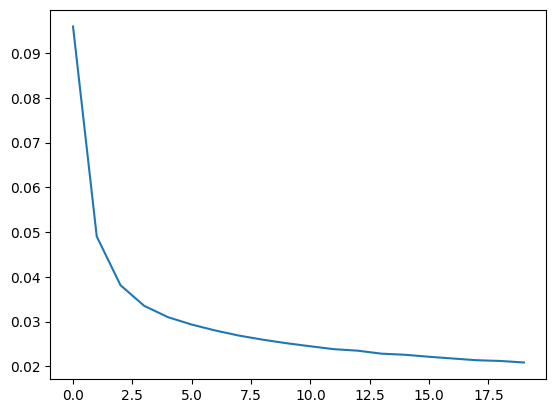

In [11]:
device = torch.device("cpu")
ni = 28*28
nh = 300
nz= 32
net = AutoEncoderConv(nz).to(device)
optimizer = optim.Adam(net.parameters(),lr=0.0001)
num_epoc = 20
ls = []
for i in range(num_epoc):
  total_loss= 0 
  for batch in train_loader:
    X = batch[0].to(device).type(torch.FloatTensor)
    z,mu,logvar,Xhat = net(X)
    loss = vae_loss(Xhat,X,mu,logvar)
    optimizer.zero_grad()
    loss.backward()
    

    optimizer.step()
    total_loss +=loss.item()
  ls.append(total_loss/len(train_loader))

plt.plot(ls)




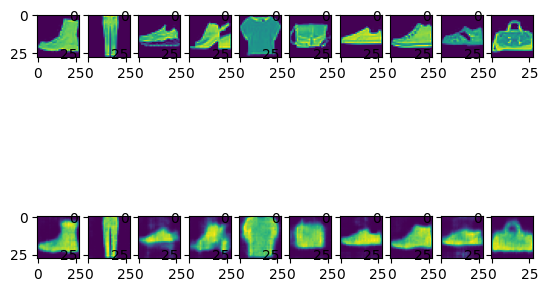

In [12]:
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy())

In [13]:
with torch.no_grad():
  net.eval()
  z = torch.randn(10,nz).to(device)


Xgen = net.decoder(z)

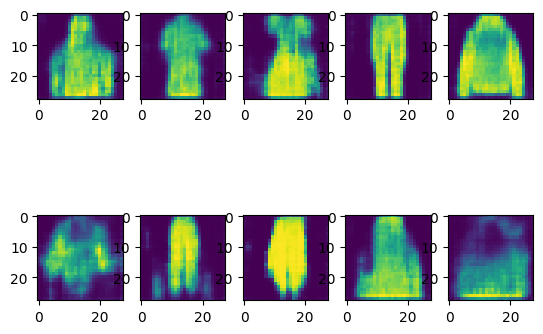

In [14]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xgen.cpu().detach().numpy()[i,0,:,:])